# Final Year Project - Times of Malta Image Analysis Section

## Overview

In this section, the images and their respective information scraped from the Times of Malta website and saved into the csv files are used to train a model which will serve as a binary classifier. Hence, this model when given an image will be able to evaluate whether it is an inset image or not.

## Installing / Importing Packages

The following packages are required for the notebook to work.

In [1]:
#Importing necessary packages
import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf
import glob
import pandas as pd
from PIL import Image
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential

## Setting List of Paths

Three lists are being created to store the paths to the article information csv file, image information csv file and the folder containing the images themselves.

In [2]:
#Creating list of paths to article information, image information csv files and folders containing images
articleInformationPaths = ['.\\TOM_Dataset\\TOM_Dataset_Inset\\Article_Information.csv', '.\\TOM_Dataset\\TOM_Dataset_Business\\Article_Information.csv', '.\\TOM_Dataset\\TOM_Dataset_National\\Article_Information.csv', '.\\TOM_Dataset\\TOM_Dataset_Opinion\\Article_Information.csv', '.\\TOM_Dataset\\TOM_Dataset_Sport\\Article_Information.csv', '.\\TOM_Dataset\\TOM_Dataset_World\\Article_Information.csv']
imageInformationPaths = ['.\\TOM_Dataset\\TOM_Dataset_Inset\\Image_Information.csv', '.\\TOM_Dataset\\TOM_Dataset_Business\\Image_Information.csv', '.\\TOM_Dataset\\TOM_Dataset_National\\Image_Information.csv', '.\\TOM_Dataset\\TOM_Dataset_Opinion\\Image_Information.csv', '.\\TOM_Dataset\\TOM_Dataset_Sport\\Image_Information.csv', '.\\TOM_Dataset\\TOM_Dataset_World\\Image_Information.csv']
imagePaths = ['.\\TOM_Dataset\\TOM_Dataset_Inset\\img', '.\\TOM_Dataset\\TOM_Dataset_Business\\img', '.\\TOM_Dataset\\TOM_Dataset_National\\img', '.\\TOM_Dataset\\TOM_Dataset_Opinion\\img', '.\\TOM_Dataset\\TOM_Dataset_Sport\\img', '.\\TOM_Dataset\\TOM_Dataset_World\\img']

## Setting Folders of Inset and Non-Inset Images

The image information csv files are opened and depending on whether the Inset attribute is set to True or False, the image is renamed and stored in the corresponding folder.

In [3]:
#Setting Counters
insetCounter = 0
notInsetCounter = 0

#For each path
for (imagePath, imageInformationPath) in zip(imagePaths, imageInformationPaths):

    #Read the csv file
    csvFile = pd.read_csv(imageInformationPath)

    #For each image and its corresponding Inset attribute value in the csv file
    for (filename, fileInformation) in zip(glob.glob(imagePath + "/*"), csvFile["Inset"]):
        
        #Open the image
        image = Image.open(filename)

        #If it is Inset
        if fileInformation == True:
            
            #Save the image in the inset folder
            image.save('.\\TOM_Classification\\inset\\Image'+str(insetCounter)+".jpg")
            insetCounter = insetCounter + 1
        else:

            #Save the image in the notinset folder
            image.save('.\\TOM_Classification\\notinset\\Image'+str(notInsetCounter)+".jpg")
            notInsetCounter = notInsetCounter + 1

## Setting up Parameters

Setting parameter values to be used when training the model.

In [4]:
#Setting parameters to be used
batchSize = 32
imageHeight = 180
imageWidth = 180

#Path from where to retrieve images
dataDirectory = ".\\TOM_Classification\\"

## Splitting Images into Training Set and Validation Set

Using the image_dataset_from_directory() function provided by Tensorflow, the training set and validation set are created and saved into their respective variables.

In [5]:
#Getting Training Set
trainingSet = tf.keras.utils.image_dataset_from_directory(
  dataDirectory,
  validation_split = 0.2,
  subset = "training",
  seed = 123,
  image_size = (imageHeight, imageWidth),
  batch_size = batchSize)

Found 1442 files belonging to 2 classes.
Using 1154 files for training.


In [6]:
#Getting Validation Set
validationSet = tf.keras.utils.image_dataset_from_directory(
  dataDirectory,
  validation_split = 0.2,
  subset = "validation",
  seed = 123,
  image_size = (imageHeight, imageWidth),
  batch_size = batchSize)

Found 1442 files belonging to 2 classes.
Using 288 files for validation.


## Displaying Class Names

The class names found are displayed to the user.

In [7]:
#Retrieving Class Names and displaying them
classNames = trainingSet.class_names
print(classNames)

['inset', 'notinset']


## Configuring Dataset for Performance Issues

The dataset is cached to improve performance.

In [8]:
#Configuring Dataset and caching it
AUTOTUNE = tf.data.AUTOTUNE

trainingSet = trainingSet.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
validationSet = validationSet.cache().prefetch(buffer_size=AUTOTUNE)

## Normalising Data

The Training Set RGB channel values are normalised from [0, 255] to [0, 1].

In [9]:
#Normalising the data
normalisationLayer = layers.Rescaling(1./255)
normalisedSet = trainingSet.map(lambda x, y: (normalisationLayer(x), y))
imageBatch, labelsBatch = next(iter(normalisedSet))
firstImage = imageBatch[0]

## Creating the Model

The Keras Sequential model includes three convolution blocks, each followed by a max pooling layer. On top, there's a fully-connected layer with 128 units activated by ReLU.

In [10]:
#Getting number of classes
numberOfClasses = len(classNames)

#Creating Keras Sequential Model
model = Sequential([
  layers.Rescaling(1./255, input_shape=(imageHeight, imageWidth, 3)),
  layers.Conv2D(16, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(32, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(64, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Flatten(),
  layers.Dense(128, activation='relu'),
  layers.Dense(numberOfClasses)
])

## Compiling the Model

The compile function is called on the model.

In [11]:
#Compiling the model
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

## Model Summary

Displaying a summary of the model.

In [12]:
#Displaying Model Summary
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 rescaling_1 (Rescaling)     (None, 180, 180, 3)       0         
                                                                 
 conv2d (Conv2D)             (None, 180, 180, 16)      448       
                                                                 
 max_pooling2d (MaxPooling2  (None, 90, 90, 16)        0         
 D)                                                              
                                                                 
 conv2d_1 (Conv2D)           (None, 90, 90, 32)        4640      
                                                                 
 max_pooling2d_1 (MaxPoolin  (None, 45, 45, 32)        0         
 g2D)                                                            
                                                                 
 conv2d_2 (Conv2D)           (None, 45, 45, 64)        1

## Training the Model

The model is now trained for six epochs using the training set. The validation set is also used to calculated the accuracy and loss.

In [13]:
#Setting number of epochs to occur
epochs = 10

#Training the Model
history = model.fit(
  trainingSet,
  validation_data = validationSet,
  epochs = epochs
)

Epoch 1/10
37/37 [==============================] - 11s 269ms/step - loss: 0.2566 - accuracy: 0.9246 - val_loss: 0.2875 - val_accuracy: 0.9444
Epoch 2/10
37/37 [==============================] - 11s 293ms/step - loss: 0.2086 - accuracy: 0.9463 - val_loss: 0.1988 - val_accuracy: 0.9444
Epoch 3/10
37/37 [==============================] - 10s 278ms/step - loss: 0.1990 - accuracy: 0.9454 - val_loss: 0.1990 - val_accuracy: 0.9444
Epoch 4/10
37/37 [==============================] - 9s 255ms/step - loss: 0.1500 - accuracy: 0.9523 - val_loss: 0.1537 - val_accuracy: 0.9479
Epoch 5/10
37/37 [==============================] - 10s 272ms/step - loss: 0.1204 - accuracy: 0.9593 - val_loss: 0.1991 - val_accuracy: 0.9479
Epoch 6/10
37/37 [==============================] - 10s 262ms/step - loss: 0.0913 - accuracy: 0.9723 - val_loss: 0.1259 - val_accuracy: 0.9653
Epoch 7/10
37/37 [==============================] - 10s 266ms/step - loss: 0.0576 - accuracy: 0.9818 - val_loss: 0.2010 - val_accuracy: 0.9653


## Displaying Accuracy and Loss Graphs

The Training and Validation Graphs are displayed showing the change in accuracy and loss over each epoch.

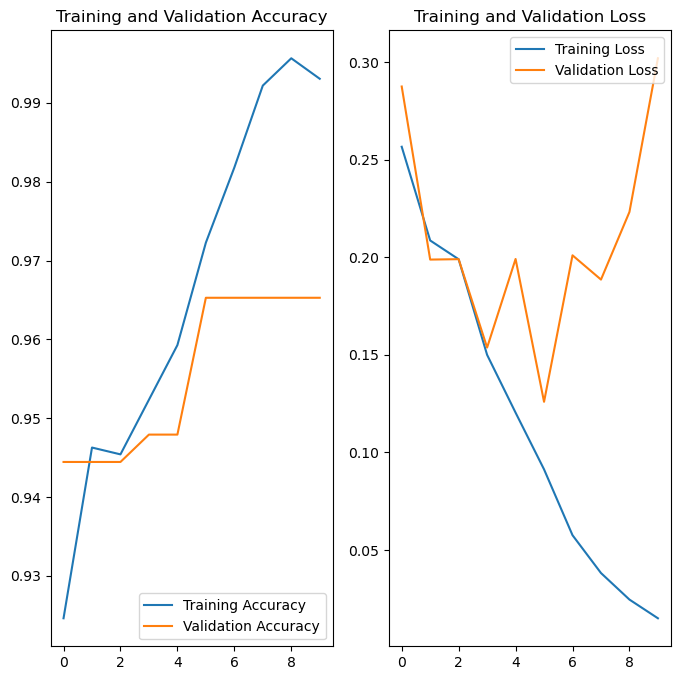

In [14]:
#Retrieving accuracy and loss of both the training set and validation set
accuracy = history.history['accuracy']
validationAccuracy = history.history['val_accuracy']
loss = history.history['loss']
validationLoss = history.history['val_loss']

#Retrieving the range of epochs
epochsRange = range(epochs)

#Plotting the Graphs
plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochsRange, accuracy, label='Training Accuracy')
plt.plot(epochsRange, validationAccuracy, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochsRange, loss, label='Training Loss')
plt.plot(epochsRange, validationLoss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()